Mounted at /content/drive
MSE: 0.0010, RMSE: 0.0318, MAE: 0.0250, MAPE: 0.0421, R²: 0.9788
Average Training Time: 16.69s, Average Inference Time: 1.01s


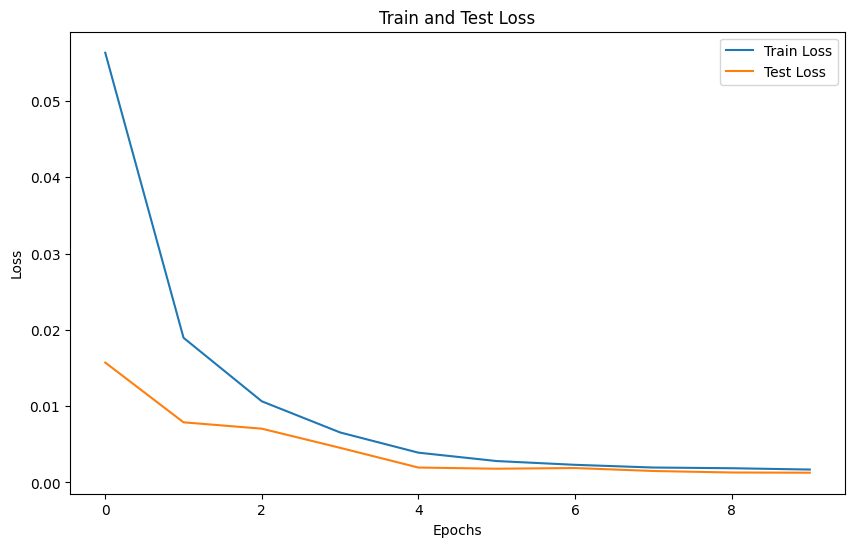

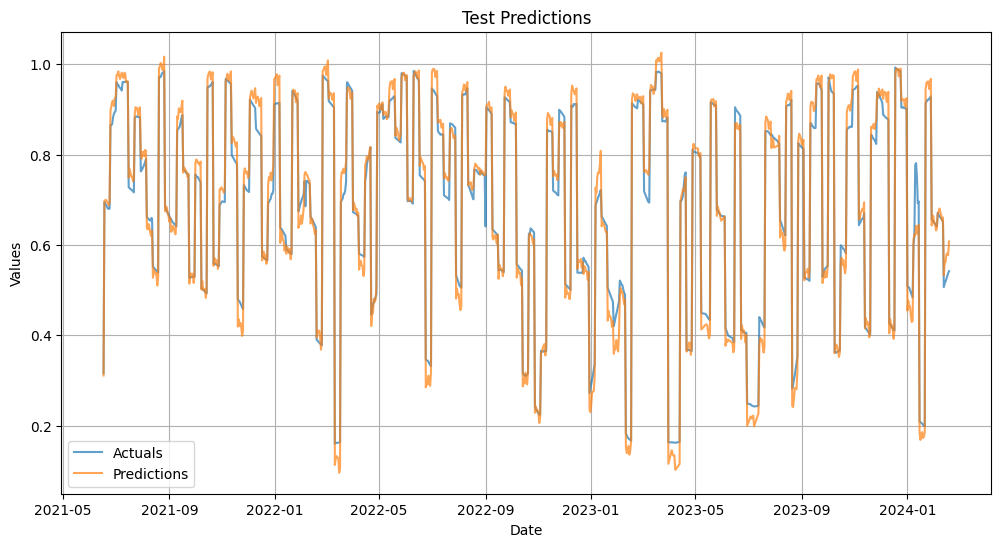

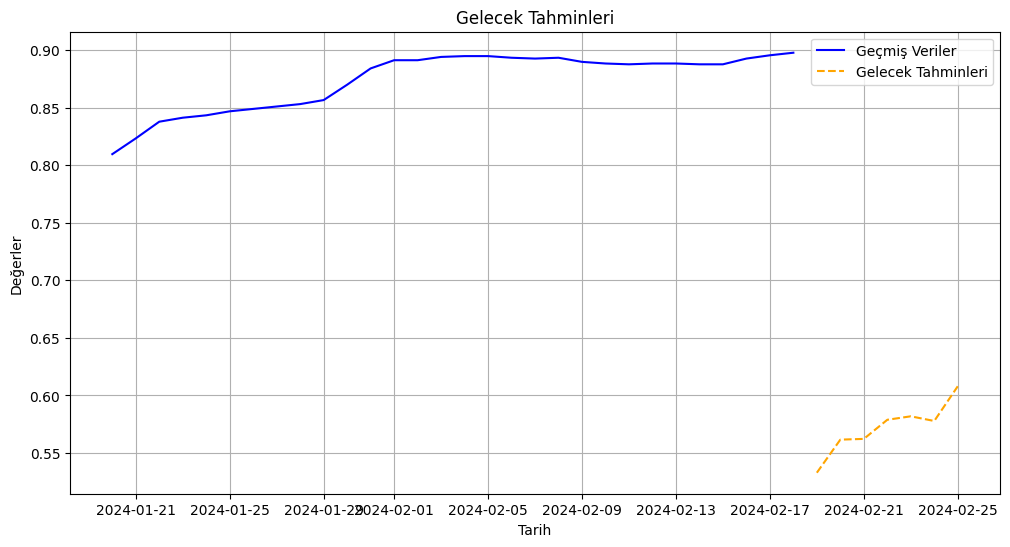

Future Predictions (console output):
Gelecek Tahminler ve Tarihler:
Tarih: 2024-02-19 00:00:00, Tahmin: 0.532873
Tarih: 2024-02-20 00:00:00, Tahmin: 0.561616
Tarih: 2024-02-21 00:00:00, Tahmin: 0.562249
Tarih: 2024-02-22 00:00:00, Tahmin: 0.578858
Tarih: 2024-02-23 00:00:00, Tahmin: 0.581871
Tarih: 2024-02-24 00:00:00, Tahmin: 0.577806
Tarih: 2024-02-25 00:00:00, Tahmin: 0.607954


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from math import sqrt
from google.colab import drive
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

drive.mount('/content/drive')
df = pd.read_json("/content/drive/MyDrive/Processed_Baraj_Data_Fixed_Deneme.json")

df['Tarih'] = pd.to_datetime(df['Tarih'])
df['Yil'] = df['Tarih'].dt.year
df['Ay'] = df['Tarih'].dt.month
df['Gun'] = df['Tarih'].dt.day
original_dates = df['Tarih']
df = df.drop(columns=['Tarih'])
df['mevsim'] = df['Ay'].apply(lambda x: 1 if x in [12, 1, 2] else (2 if x in [3, 4, 5] else (3 if x in [6, 7, 8] else 4)))
rain_columns = [col for col in df.columns if '_Yagis' in col]
df['toplam_yağış'] = df[rain_columns].sum(axis=1)
df['kümülatif_yağış_7gün'] = df['toplam_yağış'].rolling(window=7).sum()
df['yağış_lag_1'] = df['toplam_yağış'].shift(1)
df['yağış_lag_2'] = df['toplam_yağış'].shift(2)
df.fillna(0, inplace=True)

target_column = "Omerli_Doluluk"
input_features = df.drop(columns=[target_column]).values
target_values = df[target_column].values

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(input_features)
scaled_target = scaler.fit_transform(target_values.reshape(-1, 1))

def create_sequences(data, target, input_window, output_window):
    X, y = [], []
    for i in range(len(data) - input_window - output_window):
        X.append(data[i:i+input_window])
        y.append(target[i+input_window:i+input_window+output_window])
    return np.array(X), np.array(y)

input_window = 30
output_window = 7
X, y = create_sequences(scaled_features, scaled_target, input_window, output_window)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_train = y_train.squeeze(-1)
y_test = y_test.squeeze(-1)

batch_size = 64
train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

class VanillaTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim=64, num_heads=8, dropout=0.1):
        super(VanillaTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True)  # batch_first=True
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, embed_dim)
        x = self.transformer_encoder(x)  # (batch, seq_len, embed_dim)
        x = self.fc_out(x[:, -1, :])  # (batch, output_dim)
        return x.unsqueeze(-1)  # (batch, output_dim, 1)

input_dim = X_train.shape[2]
output_dim = y_train.shape[1]
embed_dim = 64
num_heads = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaTransformer(input_dim=input_dim, output_dim=output_dim, embed_dim=embed_dim, num_heads=num_heads).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, test_losses = [], []
train_times, inference_times = [], []

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(-1), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_times.append(time.time() - start_time)
    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    test_loss = 0
    predictions, actuals = [], []
    with torch.no_grad():
        start_inference_time = time.time()
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze(-1)
            test_loss += criterion(outputs, y_batch).item()
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
        inference_times.append(time.time() - start_inference_time)
    test_losses.append(test_loss / len(test_loader))

actuals = np.concatenate(actuals, axis=0).flatten()
predictions = np.concatenate(predictions, axis=0).flatten()
actuals_real = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
predictions_real = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Metrics
mse = mean_squared_error(actuals_real, predictions_real)
mape = mean_absolute_percentage_error(actuals_real, predictions_real)
mae = mean_absolute_error(actuals_real, predictions_real)
rmse = sqrt(mse)
r2 = r2_score(actuals_real, predictions_real)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}, R²: {r2:.4f}")
print(f"Average Training Time: {np.mean(train_times):.2f}s, Average Inference Time: {np.mean(inference_times):.2f}s")

# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

# Test veri setine ait zaman damgalarını eşleştirme
test_dates = original_dates[-len(y_test):]  # Test veri setine karşılık gelen tarih aralığını seçiyoruz

# Tahminleri ve gerçek değerleri çiz
plt.plot(test_dates, actuals_real[-len(test_dates):], label="Actuals", alpha=0.7)
plt.plot(test_dates, predictions_real[-len(test_dates):], label="Predictions", alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Test Predictions")
plt.legend()
plt.grid()
plt.show()

# Future predictions
future_input = X_test[-1:].clone().detach().to(device)
model.eval()
with torch.no_grad():
    future_predictions = model(future_input).cpu().numpy().flatten()
future_predictions_real = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()

# Gelecek tahminler için tarihleri oluştur
future_dates = pd.date_range(start=original_dates.iloc[-1] + pd.Timedelta(days=1), periods=output_window, freq="D")
# Gelecek tahmin grafiği
plt.figure(figsize=(12, 6))

# Geçmiş veri çizimi (örnek olarak son 30 gün)
plt.plot(
    original_dates[-30:],
    scaler.inverse_transform(target_values[-30:].reshape(-1, 1)),
    label="Geçmiş Veriler",
    color="blue"
)

# Gelecek tahmin çizimi
plt.plot(
    future_dates,
    future_predictions_real,
    label="Gelecek Tahminleri",
    linestyle="--",
    color="orange"
)

plt.xlabel("Tarih")
plt.ylabel("Değerler")
plt.title("Gelecek Tahminleri")
plt.legend()
plt.grid()
plt.show()

# Print future predictions
print("Future Predictions (console output):")
print("Gelecek Tahminler ve Tarihler:")
for date, value in zip(future_dates, future_predictions_real):
    print(f"Tarih: {date}, Tahmin: {value:.6f}")
